# Running TARDIS with a Custom Packet Source

By default, TARDIS generates energy packets using its `BasePacketSource` class, which models the photosphere of the supernova as a perfect blackbody (see [Energy Packet Initialization](../../physics/montecarlo/initialization.ipynb)). However, users may create their own packet source, as will be shown in this notebook. In order to do this, a user must create a class (that can but does not have to inherit from `BasePacketSource`) which contains a method `create_packets` that takes in (in this order):
- the photospheric temperature
- the number of packets
- a random number generator
- the photospheric radius

and returns arrays of the radii, frequencies, propogation directions, and energies of the ensemble of packets (once again see [Energy Packet Initialization](../../physics/montecarlo/initialization.ipynb) for more information). To use your packet source in a run of TARDIS, you must pass an instance of your class into the `run_tardis` function under the `packet_source` keyword argument.

.. note:: In both the `BasePacketSource` class and in the example here, all packets are generated at the same radius. This need not be true in general (although the `create_packets` method should only take in a single radius as its argument).

We show an example of how a custom packet source is used:

In [1]:
# Import necessary packages
import numpy as np
from tardis import constants as const
from astropy import units as u
from tardis.montecarlo.packet_source import BasePacketSource
from tardis import run_tardis
import matplotlib.pyplot as plt
from tardis.io.atom_data import download_atom_data

/usr/share/miniconda3/envs/tardis/lib/python3.8/site-packages/traitlets/traitlets.py:3044: FutureWarning: --rc={'figure.dpi': 96} for dict-traits is deprecated in traitlets 5.0. You can pass --rc <key=value> ... multiple times to add items to a dict.
  warn(


Iterations:          0/? [00:00<?, ?it/s]

Packets:             0/? [00:00<?, ?it/s]

In [2]:
# Download the atomic data used for a run of TARDIS
download_atom_data('kurucz_cd23_chianti_H_He')

In [3]:
# Create a packet source class that contains a create_packets method
class TruncBlackbodySource(BasePacketSource):
    """
        Custom inner boundary source class to replace the Blackbody source
        with a truncated Blackbody source.
    """
    
    def __init__(self, seed, truncation_wavelength):
        super().__init__(seed)
        self.rng = np.random.default_rng(seed=seed)
        self.truncation_wavelength = truncation_wavelength
    
    def create_packets(self, T, no_of_packets, rng, radius,
                       drawing_sample_size=None):
        """
        Packet source that generates a truncated Blackbody source.
        
        Parameters
        ----------
        T : float
            Blackbody temperature
        no_of_packets : int
            number of packets to be created
        truncation_wavelength : float
            truncation wavelength in Angstrom. 
            Only wavelengths higher than the truncation wavelength
            will be sampled.
        """
        
        # Makes uniform array of packet radii
        radii = np.ones(no_of_packets) * radius

        # Use mus and energies from normal blackbody source.
        mus = self.create_zero_limb_darkening_packet_mus(no_of_packets, self.rng)
        energies = self.create_uniform_packet_energies(no_of_packets, self.rng)

        # If not specified, draw 2 times as many packets and reject any beyond no_of_packets.
        if drawing_sample_size is None:
            drawing_sample_size = 2 * no_of_packets

        # Blackbody will be truncated below truncation_wavelength / above truncation_frequency.
        truncation_frequency = u.Quantity(self.truncation_wavelength, u.Angstrom).to(
                                          u.Hz, equivalencies=u.spectral()).value
        
        # Draw nus from blackbody distribution and reject based on truncation_frequency.
        # If more nus.shape[0] > no_of_packets use only the first no_of_packets.
        nus = self.create_blackbody_packet_nus(T, drawing_sample_size, self.rng)
        nus = nus[nus<truncation_frequency][:no_of_packets]
        
        
        # Only required if the truncation wavelength is too big compared to the maximum 
        # of the blackbody distribution. Keep sampling until nus.shape[0] > no_of_packets.
        while nus.shape[0] < no_of_packets:
            additional_nus = self.create_blackbody_packet_nus(
                T, drawing_sample_size, self.rng
            )
            mask = additional_nus < truncation_frequency
            additional_nus = additional_nus[mask][:no_of_packets]
            nus = np.hstack([nus, additional_nus])[:no_of_packets]
            
        return radii, nus, mus, energies

In [4]:
# Call an instance of the packet source class
packet_source = TruncBlackbodySource(
    53253, truncation_wavelength=2000
)

We now run TARDIS both with and without our custom packet source, and we compare the results:

In [5]:
mdl = run_tardis('tardis_example.yml',
                 packet_source=packet_source)
mdl_norm = run_tardis('tardis_example.yml')

[tardis.plasma.standard_plasmas][INFO   ]  
	
	Reading Atomic Data from kurucz_cd23_chianti_H_He.h5 (standard_plasmas.py:92)


[tardis.io.atom_data.util][INFO   ]  
	
	Atom Data kurucz_cd23_chianti_H_He.h5 not found in local path.
	Exists in TARDIS Data repo /home/runner/Downloads/tardis-data/kurucz_cd23_chianti_H_He.h5 (util.py:33)


[tardis.io.atom_data.base][INFO   ]  
	Reading Atom Data with: UUID = 6f7b09e887a311e7a06b246e96350010 MD5  = 864f1753714343c41f99cb065710cace  (base.py:203)


[tardis.io.atom_data.base][INFO   ]  
	Non provided Atomic Data: synpp_refs, photoionization_data, yg_data, two_photon_data (base.py:207)


[py.warnings         ][WARNING]  
	/usr/share/miniconda3/envs/tardis/lib/python3.8/site-packages/tardis-22.4.24.1.dev951+g974fce4a-py3.8.egg/tardis/plasma/properties/radiative_properties.py:93: RuntimeWarning: invalid value encountered in true_divide
  (g_lower * n_upper) / (g_upper * n_lower)
 (warnings.py:109)


[py.warnings         ][WARNING]  
	/usr/share/miniconda3/envs/tardis/lib/python3.8/site-packages/tardis-22.4.24.1.dev951+g974fce4a-py3.8.egg/tardis/plasma/properties/radiative_properties.py:93: RuntimeWarning: invalid value encountered in true_divide
  (g_lower * n_upper) / (g_upper * n_lower)
 (warnings.py:109)


[tardis.simulation.base][INFO   ]  
	
	Starting iteration 1 of 20 (base.py:377)


TqdmHBox(children=(HTML(value='Iterations:', layout=Layout(width='6%')), FloatProgress(value=0.0, layout=Layou…

TqdmHBox(children=(HTML(value='Packets:   ', layout=Layout(width='6%')), FloatProgress(value=0.0, layout=Layou…

[tardis.simulation.base][INFO   ]  
	
	Luminosity emitted   = 8.037e+42 erg / s
	Luminosity absorbed  = 2.571e+42 erg / s
	Luminosity requested = 1.059e+43 erg / s
 (base.py:546)


[tardis.simulation.base][INFO   ]  
	
	Plasma stratification: (base.py:514)


Shell No.,t_rad,next_t_rad,w,next_w
0,9.93e+03,9.42e+03,0.4,0.674
5,9.85e+03,9.74e+03,0.211,0.24
10,9.78e+03,9.63e+03,0.143,0.145
15,9.71e+03,9.36e+03,0.105,0.109


[tardis.simulation.base][INFO   ]  
	
	Current t_inner = 9933.952 K
	Expected t_inner for next iteration = 10669.203 K
 (base.py:541)


[py.warnings         ][WARNING]  
	/usr/share/miniconda3/envs/tardis/lib/python3.8/site-packages/tardis-22.4.24.1.dev951+g974fce4a-py3.8.egg/tardis/plasma/properties/radiative_properties.py:93: RuntimeWarning: invalid value encountered in true_divide
  (g_lower * n_upper) / (g_upper * n_lower)
 (warnings.py:109)


[tardis.simulation.base][INFO   ]  
	
	Starting iteration 2 of 20 (base.py:377)


[tardis.simulation.base][INFO   ]  
	
	Luminosity emitted   = 1.057e+43 erg / s
	Luminosity absorbed  = 3.539e+42 erg / s
	Luminosity requested = 1.059e+43 erg / s
 (base.py:546)


[tardis.simulation.base][INFO   ]  
	
	Plasma stratification: (base.py:514)


Shell No.,t_rad,next_t_rad,w,next_w
0,9.42e+03,9.62e+03,0.674,0.833
5,9.74e+03,9.89e+03,0.24,0.302
10,9.63e+03,9.82e+03,0.145,0.177
15,9.36e+03,9.68e+03,0.109,0.125


[tardis.simulation.base][INFO   ]  
	
	Current t_inner = 10669.203 K
	Expected t_inner for next iteration = 10675.465 K
 (base.py:541)


[tardis.simulation.base][INFO   ]  
	
	Starting iteration 3 of 20 (base.py:377)


[tardis.simulation.base][INFO   ]  
	
	Luminosity emitted   = 1.069e+43 erg / s
	Luminosity absorbed  = 3.457e+42 erg / s
	Luminosity requested = 1.059e+43 erg / s
 (base.py:546)


[tardis.simulation.base][INFO   ]  
	Iteration converged 1/4 consecutive times. (base.py:258)


[tardis.simulation.base][INFO   ]  
	
	Plasma stratification: (base.py:514)


Shell No.,t_rad,next_t_rad,w,next_w
0,9.62e+03,9.7e+03,0.833,0.806
5,9.89e+03,9.93e+03,0.302,0.298
10,9.82e+03,9.79e+03,0.177,0.183
15,9.68e+03,9.65e+03,0.125,0.128


[tardis.simulation.base][INFO   ]  
	
	Current t_inner = 10675.465 K
	Expected t_inner for next iteration = 10651.837 K
 (base.py:541)


[tardis.simulation.base][INFO   ]  
	
	Starting iteration 4 of 20 (base.py:377)


[tardis.simulation.base][INFO   ]  
	
	Luminosity emitted   = 1.055e+43 erg / s
	Luminosity absorbed  = 3.476e+42 erg / s
	Luminosity requested = 1.059e+43 erg / s
 (base.py:546)


[tardis.simulation.base][INFO   ]  
	Iteration converged 2/4 consecutive times. (base.py:258)


[tardis.simulation.base][INFO   ]  
	
	Plasma stratification: (base.py:514)


Shell No.,t_rad,next_t_rad,w,next_w
0,9.7e+03,9.65e+03,0.806,0.816
5,9.93e+03,9.88e+03,0.298,0.297
10,9.79e+03,9.79e+03,0.183,0.177
15,9.65e+03,9.6e+03,0.128,0.129


[tardis.simulation.base][INFO   ]  
	
	Current t_inner = 10651.837 K
	Expected t_inner for next iteration = 10663.586 K
 (base.py:541)


[tardis.simulation.base][INFO   ]  
	
	Starting iteration 5 of 20 (base.py:377)


[tardis.simulation.base][INFO   ]  
	
	Luminosity emitted   = 1.060e+43 erg / s
	Luminosity absorbed  = 3.476e+42 erg / s
	Luminosity requested = 1.059e+43 erg / s
 (base.py:546)


[tardis.simulation.base][INFO   ]  
	Iteration converged 3/4 consecutive times. (base.py:258)


[tardis.simulation.base][INFO   ]  
	
	Plasma stratification: (base.py:514)


Shell No.,t_rad,next_t_rad,w,next_w
0,9.65e+03,9.68e+03,0.816,0.803
5,9.88e+03,9.88e+03,0.297,0.301
10,9.79e+03,9.86e+03,0.177,0.176
15,9.6e+03,9.67e+03,0.129,0.126


[tardis.simulation.base][INFO   ]  
	
	Current t_inner = 10663.586 K
	Expected t_inner for next iteration = 10660.699 K
 (base.py:541)


[tardis.simulation.base][INFO   ]  
	
	Starting iteration 6 of 20 (base.py:377)


[tardis.simulation.base][INFO   ]  
	
	Luminosity emitted   = 1.064e+43 erg / s
	Luminosity absorbed  = 3.421e+42 erg / s
	Luminosity requested = 1.059e+43 erg / s
 (base.py:546)


[tardis.simulation.base][INFO   ]  
	Iteration converged 4/4 consecutive times. (base.py:258)


[tardis.simulation.base][INFO   ]  
	
	Plasma stratification: (base.py:514)


Shell No.,t_rad,next_t_rad,w,next_w
0,9.68e+03,9.67e+03,0.803,0.811
5,9.88e+03,1e+04,0.301,0.29
10,9.86e+03,9.87e+03,0.176,0.175
15,9.67e+03,9.68e+03,0.126,0.126


[tardis.simulation.base][INFO   ]  
	
	Current t_inner = 10660.699 K
	Expected t_inner for next iteration = 10647.660 K
 (base.py:541)


[tardis.simulation.base][INFO   ]  
	
	Starting iteration 7 of 20 (base.py:377)


[tardis.simulation.base][INFO   ]  
	
	Luminosity emitted   = 1.059e+43 erg / s
	Luminosity absorbed  = 3.415e+42 erg / s
	Luminosity requested = 1.059e+43 erg / s
 (base.py:546)


[tardis.simulation.base][INFO   ]  
	Iteration converged 5/4 consecutive times. (base.py:258)


[tardis.simulation.base][INFO   ]  
	
	Plasma stratification: (base.py:514)


Shell No.,t_rad,next_t_rad,w,next_w
0,9.67e+03,9.66e+03,0.811,0.802
5,1e+04,9.87e+03,0.29,0.3
10,9.87e+03,9.86e+03,0.175,0.175
15,9.68e+03,9.61e+03,0.126,0.129


[tardis.simulation.base][INFO   ]  
	
	Current t_inner = 10647.660 K
	Expected t_inner for next iteration = 10649.199 K
 (base.py:541)


[tardis.simulation.base][INFO   ]  
	
	Starting iteration 8 of 20 (base.py:377)


[tardis.simulation.base][INFO   ]  
	
	Luminosity emitted   = 1.057e+43 erg / s
	Luminosity absorbed  = 3.432e+42 erg / s
	Luminosity requested = 1.059e+43 erg / s
 (base.py:546)


[tardis.simulation.base][INFO   ]  
	Iteration converged 6/4 consecutive times. (base.py:258)


[tardis.simulation.base][INFO   ]  
	
	Plasma stratification: (base.py:514)


Shell No.,t_rad,next_t_rad,w,next_w
0,9.66e+03,9.68e+03,0.802,0.803
5,9.87e+03,9.96e+03,0.3,0.292
10,9.86e+03,9.89e+03,0.175,0.172
15,9.61e+03,9.66e+03,0.129,0.126


[tardis.simulation.base][INFO   ]  
	
	Current t_inner = 10649.199 K
	Expected t_inner for next iteration = 10653.699 K
 (base.py:541)


[tardis.simulation.base][INFO   ]  
	
	Starting iteration 9 of 20 (base.py:377)


[tardis.simulation.base][INFO   ]  
	
	Luminosity emitted   = 1.057e+43 erg / s
	Luminosity absorbed  = 3.464e+42 erg / s
	Luminosity requested = 1.059e+43 erg / s
 (base.py:546)


[tardis.simulation.base][INFO   ]  
	Iteration converged 7/4 consecutive times. (base.py:258)


[tardis.simulation.base][INFO   ]  
	
	Plasma stratification: (base.py:514)


Shell No.,t_rad,next_t_rad,w,next_w
0,9.68e+03,9.69e+03,0.803,0.8
5,9.96e+03,9.99e+03,0.292,0.289
10,9.89e+03,9.94e+03,0.172,0.168
15,9.66e+03,9.74e+03,0.126,0.122


[tardis.simulation.base][INFO   ]  
	
	Current t_inner = 10653.699 K
	Expected t_inner for next iteration = 10660.676 K
 (base.py:541)


[tardis.simulation.base][INFO   ]  
	
	Starting iteration 10 of 20 (base.py:377)


[tardis.simulation.base][INFO   ]  
	
	Luminosity emitted   = 1.063e+43 erg / s
	Luminosity absorbed  = 3.441e+42 erg / s
	Luminosity requested = 1.059e+43 erg / s
 (base.py:546)


[tardis.simulation.base][INFO   ]  
	Iteration converged 8/4 consecutive times. (base.py:258)


[tardis.simulation.base][INFO   ]  
	
	Plasma stratification: (base.py:514)


Shell No.,t_rad,next_t_rad,w,next_w
0,9.69e+03,9.69e+03,0.8,0.805
5,9.99e+03,9.97e+03,0.289,0.29
10,9.94e+03,9.84e+03,0.168,0.177
15,9.74e+03,9.65e+03,0.122,0.128


[tardis.simulation.base][INFO   ]  
	
	Current t_inner = 10660.676 K
	Expected t_inner for next iteration = 10651.860 K
 (base.py:541)


[tardis.simulation.base][INFO   ]  
	
	Starting iteration 11 of 20 (base.py:377)


[tardis.simulation.base][INFO   ]  
	
	Luminosity emitted   = 1.055e+43 erg / s
	Luminosity absorbed  = 3.470e+42 erg / s
	Luminosity requested = 1.059e+43 erg / s
 (base.py:546)


[tardis.simulation.base][INFO   ]  
	Iteration converged 9/4 consecutive times. (base.py:258)


[tardis.simulation.base][INFO   ]  
	
	Plasma stratification: (base.py:514)


Shell No.,t_rad,next_t_rad,w,next_w
0,9.69e+03,9.68e+03,0.805,0.804
5,9.97e+03,1e+04,0.29,0.282
10,9.84e+03,9.9e+03,0.177,0.171
15,9.65e+03,9.71e+03,0.128,0.123


[tardis.simulation.base][INFO   ]  
	
	Current t_inner = 10651.860 K
	Expected t_inner for next iteration = 10662.765 K
 (base.py:541)


[tardis.simulation.base][INFO   ]  
	
	Starting iteration 12 of 20 (base.py:377)


[tardis.simulation.base][INFO   ]  
	
	Luminosity emitted   = 1.065e+43 erg / s
	Luminosity absorbed  = 3.429e+42 erg / s
	Luminosity requested = 1.059e+43 erg / s
 (base.py:546)


[tardis.simulation.base][INFO   ]  
	Iteration converged 10/4 consecutive times. (base.py:258)


[tardis.simulation.base][INFO   ]  
	
	Plasma stratification: (base.py:514)


Shell No.,t_rad,next_t_rad,w,next_w
0,9.68e+03,9.65e+03,0.804,0.82
5,1e+04,9.99e+03,0.282,0.287
10,9.9e+03,9.96e+03,0.171,0.168
15,9.71e+03,9.72e+03,0.123,0.124


[tardis.simulation.base][INFO   ]  
	
	Current t_inner = 10662.765 K
	Expected t_inner for next iteration = 10647.529 K
 (base.py:541)


[tardis.simulation.base][INFO   ]  
	
	Starting iteration 13 of 20 (base.py:377)


[tardis.simulation.base][INFO   ]  
	
	Luminosity emitted   = 1.059e+43 erg / s
	Luminosity absorbed  = 3.406e+42 erg / s
	Luminosity requested = 1.059e+43 erg / s
 (base.py:546)


[tardis.simulation.base][INFO   ]  
	Iteration converged 11/4 consecutive times. (base.py:258)


[tardis.simulation.base][INFO   ]  
	
	Plasma stratification: (base.py:514)


Shell No.,t_rad,next_t_rad,w,next_w
0,9.65e+03,9.68e+03,0.82,0.802
5,9.99e+03,1e+04,0.287,0.283
10,9.96e+03,9.93e+03,0.168,0.17
15,9.72e+03,9.64e+03,0.124,0.128


[tardis.simulation.base][INFO   ]  
	
	Current t_inner = 10647.529 K
	Expected t_inner for next iteration = 10647.025 K
 (base.py:541)


[tardis.simulation.base][INFO   ]  
	
	Starting iteration 14 of 20 (base.py:377)


[tardis.simulation.base][INFO   ]  
	
	Luminosity emitted   = 1.058e+43 erg / s
	Luminosity absorbed  = 3.415e+42 erg / s
	Luminosity requested = 1.059e+43 erg / s
 (base.py:546)


[tardis.simulation.base][INFO   ]  
	Iteration converged 12/4 consecutive times. (base.py:258)


[tardis.simulation.base][INFO   ]  
	
	Plasma stratification: (base.py:514)


Shell No.,t_rad,next_t_rad,w,next_w
0,9.68e+03,9.66e+03,0.802,0.807
5,1e+04,1e+04,0.283,0.288
10,9.93e+03,9.94e+03,0.17,0.169
15,9.64e+03,9.7e+03,0.128,0.125


[tardis.simulation.base][INFO   ]  
	
	Current t_inner = 10647.025 K
	Expected t_inner for next iteration = 10649.748 K
 (base.py:541)


[tardis.simulation.base][INFO   ]  
	
	Starting iteration 15 of 20 (base.py:377)


[tardis.simulation.base][INFO   ]  
	
	Luminosity emitted   = 1.055e+43 erg / s
	Luminosity absorbed  = 3.455e+42 erg / s
	Luminosity requested = 1.059e+43 erg / s
 (base.py:546)


[tardis.simulation.base][INFO   ]  
	Iteration converged 13/4 consecutive times. (base.py:258)


[tardis.simulation.base][INFO   ]  
	
	Plasma stratification: (base.py:514)


Shell No.,t_rad,next_t_rad,w,next_w
0,9.66e+03,9.63e+03,0.807,0.815
5,1e+04,9.96e+03,0.288,0.29
10,9.94e+03,9.89e+03,0.169,0.172
15,9.7e+03,9.66e+03,0.125,0.127


[tardis.simulation.base][INFO   ]  
	
	Current t_inner = 10649.748 K
	Expected t_inner for next iteration = 10659.500 K
 (base.py:541)


[tardis.simulation.base][INFO   ]  
	
	Starting iteration 16 of 20 (base.py:377)


[tardis.simulation.base][INFO   ]  
	
	Luminosity emitted   = 1.065e+43 erg / s
	Luminosity absorbed  = 3.412e+42 erg / s
	Luminosity requested = 1.059e+43 erg / s
 (base.py:546)


[tardis.simulation.base][INFO   ]  
	Iteration converged 14/4 consecutive times. (base.py:258)


[tardis.simulation.base][INFO   ]  
	
	Plasma stratification: (base.py:514)


Shell No.,t_rad,next_t_rad,w,next_w
0,9.63e+03,9.63e+03,0.815,0.817
5,9.96e+03,9.99e+03,0.29,0.286
10,9.89e+03,9.89e+03,0.172,0.174
15,9.66e+03,9.65e+03,0.127,0.128


[tardis.simulation.base][INFO   ]  
	
	Current t_inner = 10659.500 K
	Expected t_inner for next iteration = 10644.516 K
 (base.py:541)


[tardis.simulation.base][INFO   ]  
	
	Starting iteration 17 of 20 (base.py:377)


[tardis.simulation.base][INFO   ]  
	
	Luminosity emitted   = 1.057e+43 erg / s
	Luminosity absorbed  = 3.411e+42 erg / s
	Luminosity requested = 1.059e+43 erg / s
 (base.py:546)


[tardis.simulation.base][INFO   ]  
	
	Plasma stratification: (base.py:514)


Shell No.,t_rad,next_t_rad,w,next_w
0,9.63e+03,9.66e+03,0.817,0.806
5,9.99e+03,1e+04,0.286,0.283
10,9.89e+03,9.89e+03,0.174,0.171
15,9.65e+03,9.77e+03,0.128,0.121


[tardis.simulation.base][INFO   ]  
	
	Current t_inner = 10644.516 K
	Expected t_inner for next iteration = 10649.248 K
 (base.py:541)


[tardis.simulation.base][INFO   ]  
	
	Starting iteration 18 of 20 (base.py:377)


[tardis.simulation.base][INFO   ]  
	
	Luminosity emitted   = 1.058e+43 erg / s
	Luminosity absorbed  = 3.424e+42 erg / s
	Luminosity requested = 1.059e+43 erg / s
 (base.py:546)


[tardis.simulation.base][INFO   ]  
	Iteration converged 1/4 consecutive times. (base.py:258)


[tardis.simulation.base][INFO   ]  
	
	Plasma stratification: (base.py:514)


Shell No.,t_rad,next_t_rad,w,next_w
0,9.66e+03,9.65e+03,0.806,0.808
5,1e+04,9.91e+03,0.283,0.295
10,9.89e+03,9.85e+03,0.171,0.176
15,9.77e+03,9.67e+03,0.121,0.126


[tardis.simulation.base][INFO   ]  
	
	Current t_inner = 10649.248 K
	Expected t_inner for next iteration = 10651.551 K
 (base.py:541)


[tardis.simulation.base][INFO   ]  
	
	Starting iteration 19 of 20 (base.py:377)


[tardis.simulation.base][INFO   ]  
	
	Luminosity emitted   = 1.059e+43 erg / s
	Luminosity absorbed  = 3.434e+42 erg / s
	Luminosity requested = 1.059e+43 erg / s
 (base.py:546)


[tardis.simulation.base][INFO   ]  
	Iteration converged 2/4 consecutive times. (base.py:258)


[tardis.simulation.base][INFO   ]  
	
	Plasma stratification: (base.py:514)


Shell No.,t_rad,next_t_rad,w,next_w
0,9.65e+03,9.64e+03,0.808,0.813
5,9.91e+03,9.96e+03,0.295,0.289
10,9.85e+03,9.9e+03,0.176,0.171
15,9.67e+03,9.66e+03,0.126,0.126


[tardis.simulation.base][INFO   ]  
	
	Current t_inner = 10651.551 K
	Expected t_inner for next iteration = 10652.913 K
 (base.py:541)


[tardis.simulation.base][INFO   ]  
	
	Starting iteration 20 of 20 (base.py:377)


[tardis.simulation.base][INFO   ]  
	
	Luminosity emitted   = 1.060e+43 erg / s
	Luminosity absorbed  = 3.427e+42 erg / s
	Luminosity requested = 1.059e+43 erg / s
 (base.py:546)


[tardis.simulation.base][INFO   ]  
	
	Simulation finished in 20 iterations 
	Simulation took 41.50 s
 (base.py:467)


[tardis.plasma.standard_plasmas][INFO   ]  
	
	Reading Atomic Data from kurucz_cd23_chianti_H_He.h5 (standard_plasmas.py:92)


[tardis.io.atom_data.util][INFO   ]  
	
	Atom Data kurucz_cd23_chianti_H_He.h5 not found in local path.
	Exists in TARDIS Data repo /home/runner/Downloads/tardis-data/kurucz_cd23_chianti_H_He.h5 (util.py:33)


[tardis.io.atom_data.base][INFO   ]  
	Reading Atom Data with: UUID = 6f7b09e887a311e7a06b246e96350010 MD5  = 864f1753714343c41f99cb065710cace  (base.py:203)


[tardis.io.atom_data.base][INFO   ]  
	Non provided Atomic Data: synpp_refs, photoionization_data, yg_data, two_photon_data (base.py:207)


[tardis.simulation.base][INFO   ]  
	
	Starting iteration 1 of 20 (base.py:377)


TqdmHBox(children=(HTML(value='Iterations:', layout=Layout(width='6%')), FloatProgress(value=0.0, layout=Layou…

TqdmHBox(children=(HTML(value='Packets:   ', layout=Layout(width='6%')), FloatProgress(value=0.0, layout=Layou…

[tardis.simulation.base][INFO   ]  
	
	Luminosity emitted   = 7.942e+42 erg / s
	Luminosity absorbed  = 2.659e+42 erg / s
	Luminosity requested = 1.059e+43 erg / s
 (base.py:546)


[tardis.simulation.base][INFO   ]  
	
	Plasma stratification: (base.py:514)


Shell No.,t_rad,next_t_rad,w,next_w
0,9.93e+03,1.01e+04,0.4,0.507
5,9.85e+03,1.02e+04,0.211,0.197
10,9.78e+03,1.01e+04,0.143,0.117
15,9.71e+03,9.87e+03,0.105,0.0869


[tardis.simulation.base][INFO   ]  
	
	Current t_inner = 9933.952 K
	Expected t_inner for next iteration = 10703.212 K
 (base.py:541)


[tardis.simulation.base][INFO   ]  
	
	Starting iteration 2 of 20 (base.py:377)


[tardis.simulation.base][INFO   ]  
	
	Luminosity emitted   = 1.071e+43 erg / s
	Luminosity absorbed  = 3.576e+42 erg / s
	Luminosity requested = 1.059e+43 erg / s
 (base.py:546)


[tardis.simulation.base][INFO   ]  
	
	Plasma stratification: (base.py:514)


Shell No.,t_rad,next_t_rad,w,next_w
0,1.01e+04,1.08e+04,0.507,0.525
5,1.02e+04,1.1e+04,0.197,0.203
10,1.01e+04,1.08e+04,0.117,0.125
15,9.87e+03,1.05e+04,0.0869,0.0933


[tardis.simulation.base][INFO   ]  
	
	Current t_inner = 10703.212 K
	Expected t_inner for next iteration = 10673.712 K
 (base.py:541)


[tardis.simulation.base][INFO   ]  
	
	Starting iteration 3 of 20 (base.py:377)


[tardis.simulation.base][INFO   ]  
	
	Luminosity emitted   = 1.074e+43 erg / s
	Luminosity absorbed  = 3.391e+42 erg / s
	Luminosity requested = 1.059e+43 erg / s
 (base.py:546)


[tardis.simulation.base][INFO   ]  
	
	Plasma stratification: (base.py:514)


Shell No.,t_rad,next_t_rad,w,next_w
0,1.08e+04,1.1e+04,0.525,0.483
5,1.1e+04,1.12e+04,0.203,0.189
10,1.08e+04,1.1e+04,0.125,0.118
15,1.05e+04,1.06e+04,0.0933,0.0895


[tardis.simulation.base][INFO   ]  
	
	Current t_inner = 10673.712 K
	Expected t_inner for next iteration = 10635.953 K
 (base.py:541)


[tardis.simulation.base][INFO   ]  
	
	Starting iteration 4 of 20 (base.py:377)


[tardis.simulation.base][INFO   ]  
	
	Luminosity emitted   = 1.058e+43 erg / s
	Luminosity absorbed  = 3.352e+42 erg / s
	Luminosity requested = 1.059e+43 erg / s
 (base.py:546)


[tardis.simulation.base][INFO   ]  
	
	Plasma stratification: (base.py:514)


Shell No.,t_rad,next_t_rad,w,next_w
0,1.1e+04,1.1e+04,0.483,0.469
5,1.12e+04,1.12e+04,0.189,0.182
10,1.1e+04,1.1e+04,0.118,0.113
15,1.06e+04,1.07e+04,0.0895,0.0861


[tardis.simulation.base][INFO   ]  
	
	Current t_inner = 10635.953 K
	Expected t_inner for next iteration = 10638.407 K
 (base.py:541)


[tardis.simulation.base][INFO   ]  
	
	Starting iteration 5 of 20 (base.py:377)


[tardis.simulation.base][INFO   ]  
	
	Luminosity emitted   = 1.055e+43 erg / s
	Luminosity absorbed  = 3.399e+42 erg / s
	Luminosity requested = 1.059e+43 erg / s
 (base.py:546)


[tardis.simulation.base][INFO   ]  
	Iteration converged 1/4 consecutive times. (base.py:258)


[tardis.simulation.base][INFO   ]  
	
	Plasma stratification: (base.py:514)


Shell No.,t_rad,next_t_rad,w,next_w
0,1.1e+04,1.1e+04,0.469,0.479
5,1.12e+04,1.13e+04,0.182,0.178
10,1.1e+04,1.1e+04,0.113,0.113
15,1.07e+04,1.07e+04,0.0861,0.0839


[tardis.simulation.base][INFO   ]  
	
	Current t_inner = 10638.407 K
	Expected t_inner for next iteration = 10650.202 K
 (base.py:541)


[tardis.simulation.base][INFO   ]  
	
	Starting iteration 6 of 20 (base.py:377)


[tardis.simulation.base][INFO   ]  
	
	Luminosity emitted   = 1.061e+43 erg / s
	Luminosity absorbed  = 3.398e+42 erg / s
	Luminosity requested = 1.059e+43 erg / s
 (base.py:546)


[tardis.simulation.base][INFO   ]  
	Iteration converged 2/4 consecutive times. (base.py:258)


[tardis.simulation.base][INFO   ]  
	
	Plasma stratification: (base.py:514)


Shell No.,t_rad,next_t_rad,w,next_w
0,1.1e+04,1.1e+04,0.479,0.47
5,1.13e+04,1.12e+04,0.178,0.185
10,1.1e+04,1.11e+04,0.113,0.112
15,1.07e+04,1.07e+04,0.0839,0.0856


[tardis.simulation.base][INFO   ]  
	
	Current t_inner = 10650.202 K
	Expected t_inner for next iteration = 10645.955 K
 (base.py:541)


[tardis.simulation.base][INFO   ]  
	
	Starting iteration 7 of 20 (base.py:377)


[tardis.simulation.base][INFO   ]  
	
	Luminosity emitted   = 1.061e+43 erg / s
	Luminosity absorbed  = 3.382e+42 erg / s
	Luminosity requested = 1.059e+43 erg / s
 (base.py:546)


[tardis.simulation.base][INFO   ]  
	Iteration converged 3/4 consecutive times. (base.py:258)


[tardis.simulation.base][INFO   ]  
	
	Plasma stratification: (base.py:514)


Shell No.,t_rad,next_t_rad,w,next_w
0,1.1e+04,1.1e+04,0.47,0.47
5,1.12e+04,1.13e+04,0.185,0.178
10,1.11e+04,1.11e+04,0.112,0.112
15,1.07e+04,1.07e+04,0.0856,0.086


[tardis.simulation.base][INFO   ]  
	
	Current t_inner = 10645.955 K
	Expected t_inner for next iteration = 10642.050 K
 (base.py:541)


[tardis.simulation.base][INFO   ]  
	
	Starting iteration 8 of 20 (base.py:377)


[tardis.simulation.base][INFO   ]  
	
	Luminosity emitted   = 1.062e+43 erg / s
	Luminosity absorbed  = 3.350e+42 erg / s
	Luminosity requested = 1.059e+43 erg / s
 (base.py:546)


[tardis.simulation.base][INFO   ]  
	Iteration converged 4/4 consecutive times. (base.py:258)


[tardis.simulation.base][INFO   ]  
	
	Plasma stratification: (base.py:514)


Shell No.,t_rad,next_t_rad,w,next_w
0,1.1e+04,1.11e+04,0.47,0.472
5,1.13e+04,1.14e+04,0.178,0.175
10,1.11e+04,1.11e+04,0.112,0.111
15,1.07e+04,1.07e+04,0.086,0.084


[tardis.simulation.base][INFO   ]  
	
	Current t_inner = 10642.050 K
	Expected t_inner for next iteration = 10636.106 K
 (base.py:541)


[tardis.simulation.base][INFO   ]  
	
	Starting iteration 9 of 20 (base.py:377)


[tardis.simulation.base][INFO   ]  
	
	Luminosity emitted   = 1.052e+43 erg / s
	Luminosity absorbed  = 3.411e+42 erg / s
	Luminosity requested = 1.059e+43 erg / s
 (base.py:546)


[tardis.simulation.base][INFO   ]  
	Iteration converged 5/4 consecutive times. (base.py:258)


[tardis.simulation.base][INFO   ]  
	
	Plasma stratification: (base.py:514)


Shell No.,t_rad,next_t_rad,w,next_w
0,1.11e+04,1.11e+04,0.472,0.469
5,1.14e+04,1.15e+04,0.175,0.17
10,1.11e+04,1.11e+04,0.111,0.109
15,1.07e+04,1.08e+04,0.084,0.0822


[tardis.simulation.base][INFO   ]  
	
	Current t_inner = 10636.106 K
	Expected t_inner for next iteration = 10654.313 K
 (base.py:541)


[tardis.simulation.base][INFO   ]  
	
	Starting iteration 10 of 20 (base.py:377)


[tardis.simulation.base][INFO   ]  
	
	Luminosity emitted   = 1.070e+43 erg / s
	Luminosity absorbed  = 3.335e+42 erg / s
	Luminosity requested = 1.059e+43 erg / s
 (base.py:546)


[tardis.simulation.base][INFO   ]  
	
	Plasma stratification: (base.py:514)


Shell No.,t_rad,next_t_rad,w,next_w
0,1.11e+04,1.1e+04,0.469,0.475
5,1.15e+04,1.14e+04,0.17,0.177
10,1.11e+04,1.11e+04,0.109,0.112
15,1.08e+04,1.06e+04,0.0822,0.0878


[tardis.simulation.base][INFO   ]  
	
	Current t_inner = 10654.313 K
	Expected t_inner for next iteration = 10628.190 K
 (base.py:541)


[tardis.simulation.base][INFO   ]  
	
	Starting iteration 11 of 20 (base.py:377)


[tardis.simulation.base][INFO   ]  
	
	Luminosity emitted   = 1.053e+43 erg / s
	Luminosity absorbed  = 3.363e+42 erg / s
	Luminosity requested = 1.059e+43 erg / s
 (base.py:546)


[tardis.simulation.base][INFO   ]  
	Iteration converged 1/4 consecutive times. (base.py:258)


[tardis.simulation.base][INFO   ]  
	
	Plasma stratification: (base.py:514)


Shell No.,t_rad,next_t_rad,w,next_w
0,1.1e+04,1.1e+04,0.475,0.472
5,1.14e+04,1.12e+04,0.177,0.184
10,1.11e+04,1.1e+04,0.112,0.114
15,1.06e+04,1.06e+04,0.0878,0.0859


[tardis.simulation.base][INFO   ]  
	
	Current t_inner = 10628.190 K
	Expected t_inner for next iteration = 10644.054 K
 (base.py:541)


[tardis.simulation.base][INFO   ]  
	
	Starting iteration 12 of 20 (base.py:377)


[tardis.simulation.base][INFO   ]  
	
	Luminosity emitted   = 1.056e+43 erg / s
	Luminosity absorbed  = 3.420e+42 erg / s
	Luminosity requested = 1.059e+43 erg / s
 (base.py:546)


[tardis.simulation.base][INFO   ]  
	
	Plasma stratification: (base.py:514)


Shell No.,t_rad,next_t_rad,w,next_w
0,1.1e+04,1.11e+04,0.472,0.467
5,1.12e+04,1.13e+04,0.184,0.176
10,1.1e+04,1.11e+04,0.114,0.11
15,1.06e+04,1.08e+04,0.0859,0.0821


[tardis.simulation.base][INFO   ]  
	
	Current t_inner = 10644.054 K
	Expected t_inner for next iteration = 10653.543 K
 (base.py:541)


[tardis.simulation.base][INFO   ]  
	
	Starting iteration 13 of 20 (base.py:377)


[tardis.simulation.base][INFO   ]  
	
	Luminosity emitted   = 1.062e+43 erg / s
	Luminosity absorbed  = 3.406e+42 erg / s
	Luminosity requested = 1.059e+43 erg / s
 (base.py:546)


[tardis.simulation.base][INFO   ]  
	Iteration converged 1/4 consecutive times. (base.py:258)


[tardis.simulation.base][INFO   ]  
	
	Plasma stratification: (base.py:514)


Shell No.,t_rad,next_t_rad,w,next_w
0,1.11e+04,1.11e+04,0.467,0.466
5,1.13e+04,1.13e+04,0.176,0.18
10,1.11e+04,1.11e+04,0.11,0.111
15,1.08e+04,1.08e+04,0.0821,0.0841


[tardis.simulation.base][INFO   ]  
	
	Current t_inner = 10653.543 K
	Expected t_inner for next iteration = 10647.277 K
 (base.py:541)


[tardis.simulation.base][INFO   ]  
	
	Starting iteration 14 of 20 (base.py:377)


[tardis.simulation.base][INFO   ]  
	
	Luminosity emitted   = 1.063e+43 erg / s
	Luminosity absorbed  = 3.369e+42 erg / s
	Luminosity requested = 1.059e+43 erg / s
 (base.py:546)


[tardis.simulation.base][INFO   ]  
	Iteration converged 2/4 consecutive times. (base.py:258)


[tardis.simulation.base][INFO   ]  
	
	Plasma stratification: (base.py:514)


Shell No.,t_rad,next_t_rad,w,next_w
0,1.11e+04,1.11e+04,0.466,0.469
5,1.13e+04,1.13e+04,0.18,0.182
10,1.11e+04,1.1e+04,0.111,0.113
15,1.08e+04,1.07e+04,0.0841,0.0854


[tardis.simulation.base][INFO   ]  
	
	Current t_inner = 10647.277 K
	Expected t_inner for next iteration = 10638.875 K
 (base.py:541)


[tardis.simulation.base][INFO   ]  
	
	Starting iteration 15 of 20 (base.py:377)


[tardis.simulation.base][INFO   ]  
	
	Luminosity emitted   = 1.053e+43 erg / s
	Luminosity absorbed  = 3.417e+42 erg / s
	Luminosity requested = 1.059e+43 erg / s
 (base.py:546)


[tardis.simulation.base][INFO   ]  
	Iteration converged 3/4 consecutive times. (base.py:258)


[tardis.simulation.base][INFO   ]  
	
	Plasma stratification: (base.py:514)


Shell No.,t_rad,next_t_rad,w,next_w
0,1.11e+04,1.1e+04,0.469,0.484
5,1.13e+04,1.13e+04,0.182,0.181
10,1.1e+04,1.1e+04,0.113,0.113
15,1.07e+04,1.07e+04,0.0854,0.0858


[tardis.simulation.base][INFO   ]  
	
	Current t_inner = 10638.875 K
	Expected t_inner for next iteration = 10655.125 K
 (base.py:541)


[tardis.simulation.base][INFO   ]  
	
	Starting iteration 16 of 20 (base.py:377)


[tardis.simulation.base][INFO   ]  
	
	Luminosity emitted   = 1.059e+43 erg / s
	Luminosity absorbed  = 3.445e+42 erg / s
	Luminosity requested = 1.059e+43 erg / s
 (base.py:546)


[tardis.simulation.base][INFO   ]  
	Iteration converged 4/4 consecutive times. (base.py:258)


[tardis.simulation.base][INFO   ]  
	
	Plasma stratification: (base.py:514)


Shell No.,t_rad,next_t_rad,w,next_w
0,1.1e+04,1.1e+04,0.484,0.472
5,1.13e+04,1.13e+04,0.181,0.177
10,1.1e+04,1.1e+04,0.113,0.113
15,1.07e+04,1.06e+04,0.0858,0.0858


[tardis.simulation.base][INFO   ]  
	
	Current t_inner = 10655.125 K
	Expected t_inner for next iteration = 10655.561 K
 (base.py:541)


[tardis.simulation.base][INFO   ]  
	
	Starting iteration 17 of 20 (base.py:377)


[tardis.simulation.base][INFO   ]  
	
	Luminosity emitted   = 1.067e+43 erg / s
	Luminosity absorbed  = 3.372e+42 erg / s
	Luminosity requested = 1.059e+43 erg / s
 (base.py:546)


[tardis.simulation.base][INFO   ]  
	
	Plasma stratification: (base.py:514)


Shell No.,t_rad,next_t_rad,w,next_w
0,1.1e+04,1.11e+04,0.472,0.468
5,1.13e+04,1.14e+04,0.177,0.175
10,1.1e+04,1.11e+04,0.113,0.11
15,1.06e+04,1.08e+04,0.0858,0.0816


[tardis.simulation.base][INFO   ]  
	
	Current t_inner = 10655.561 K
	Expected t_inner for next iteration = 10636.536 K
 (base.py:541)


[tardis.simulation.base][INFO   ]  
	
	Starting iteration 18 of 20 (base.py:377)


[tardis.simulation.base][INFO   ]  
	
	Luminosity emitted   = 1.057e+43 erg / s
	Luminosity absorbed  = 3.365e+42 erg / s
	Luminosity requested = 1.059e+43 erg / s
 (base.py:546)


[tardis.simulation.base][INFO   ]  
	Iteration converged 1/4 consecutive times. (base.py:258)


[tardis.simulation.base][INFO   ]  
	
	Plasma stratification: (base.py:514)


Shell No.,t_rad,next_t_rad,w,next_w
0,1.11e+04,1.11e+04,0.468,0.464
5,1.14e+04,1.13e+04,0.175,0.177
10,1.11e+04,1.1e+04,0.11,0.113
15,1.08e+04,1.07e+04,0.0816,0.0848


[tardis.simulation.base][INFO   ]  
	
	Current t_inner = 10636.536 K
	Expected t_inner for next iteration = 10641.692 K
 (base.py:541)


[tardis.simulation.base][INFO   ]  
	
	Starting iteration 19 of 20 (base.py:377)


[tardis.simulation.base][INFO   ]  
	
	Luminosity emitted   = 1.056e+43 erg / s
	Luminosity absorbed  = 3.405e+42 erg / s
	Luminosity requested = 1.059e+43 erg / s
 (base.py:546)


[tardis.simulation.base][INFO   ]  
	Iteration converged 2/4 consecutive times. (base.py:258)


[tardis.simulation.base][INFO   ]  
	
	Plasma stratification: (base.py:514)


Shell No.,t_rad,next_t_rad,w,next_w
0,1.11e+04,1.11e+04,0.464,0.466
5,1.13e+04,1.13e+04,0.177,0.177
10,1.1e+04,1.11e+04,0.113,0.111
15,1.07e+04,1.07e+04,0.0848,0.0853


[tardis.simulation.base][INFO   ]  
	
	Current t_inner = 10641.692 K
	Expected t_inner for next iteration = 10650.463 K
 (base.py:541)


[tardis.simulation.base][INFO   ]  
	
	Starting iteration 20 of 20 (base.py:377)


[tardis.simulation.base][INFO   ]  
	
	Luminosity emitted   = 1.061e+43 erg / s
	Luminosity absorbed  = 3.401e+42 erg / s
	Luminosity requested = 1.059e+43 erg / s
 (base.py:546)


[tardis.simulation.base][INFO   ]  
	
	Simulation finished in 20 iterations 
	Simulation took 19.87 s
 (base.py:467)


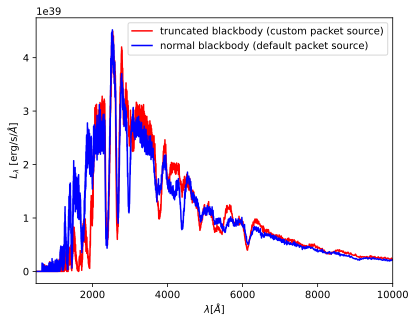

In [6]:
%matplotlib inline
plt.plot(mdl.runner.spectrum_virtual.wavelength,
         mdl.runner.spectrum_virtual.luminosity_density_lambda,
         color='red', label='truncated blackbody (custom packet source)')
plt.plot(mdl_norm.runner.spectrum_virtual.wavelength,
         mdl_norm.runner.spectrum_virtual.luminosity_density_lambda,
         color='blue', label='normal blackbody (default packet source)')
plt.xlabel('$\lambda [\AA]$')
plt.ylabel('$L_\lambda$ [erg/s/$\AA$]')
plt.xlim(500, 10000)
plt.legend()